### Library and Data Imports

In [73]:
import pandas as pd
import numpy as np
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from xgboost import XGBRegressor
from scipy import stats

## Approach for cleaning of data 
The following will be my approach for our target dataset:
1. Exploration and descriptive statistics of the dataset
2. sqlite3 database relation and design
3. Visualising feature distributions
4. Alteration on the "income" and "gh" column
5. Basic exploration of Null values
6. Pipeline steps for training
7. Discussion of results

### Exploration and descriptive statistics of the dataset

Basic information on entries, columns, non-null counts, and data types

In [74]:
nhgh = pd.read_csv('nhgh.tsv', sep = '\t')

In [75]:
nhgh.shape

(6795, 20)

In [76]:
nhgh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   seqn     6795 non-null   int64  
 1   sex      6795 non-null   object 
 2   age      6795 non-null   float64
 3   re       6795 non-null   object 
 4   income   6475 non-null   object 
 5   tx       6795 non-null   int64  
 6   dx       6795 non-null   int64  
 7   wt       6795 non-null   float64
 8   ht       6795 non-null   float64
 9   bmi      6795 non-null   float64
 10  leg      6564 non-null   float64
 11  arml     6616 non-null   float64
 12  armc     6607 non-null   float64
 13  waist    6556 non-null   float64
 14  tri      6314 non-null   float64
 15  sub      5824 non-null   float64
 16  gh       6795 non-null   float64
 17  albumin  6706 non-null   float64
 18  bun      6706 non-null   float64
 19  SCr      6706 non-null   float64
dtypes: float64(14), int64(3), object(3)
memory usage: 1.

Descriptive statistics for our target dataframe

In [77]:
nhgh.describe()

,seqn,age,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
count,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6564.000000,6616.000000,6607.000000,6556.000000,6314.000000,5824.000000,6795.000000,6706.000000,6706.000000,6706.000000
mean,56872.080500,44.285700,0.091832,0.134511,79.370625,167.042958,28.321741,38.409324,36.874607,32.485152,96.254149,18.787726,19.961556,5.676586,4.273621,12.917686,0.878627
std,3043.535776,20.594593,0.288810,0.341225,21.930903,10.264984,6.950110,3.876902,2.781616,5.297660,17.059193,8.319393,8.369083,0.964700,0.326545,5.717571,0.445238
min,51624.000000,12.000000,0.000000,0.000000,28.000000,123.300000,13.180000,20.400000,24.800000,16.800000,52.000000,2.600000,3.800000,4.000000,2.500000,1.000000,0.140000
25%,54245.500000,25.666667,0.000000,0.000000,64.000000,159.600000,23.430000,36.000000,35.000000,28.850000,83.500000,12.000000,13.000000,5.200000,4.100000,9.000000,0.700000
50%,56873.000000,43.750000,0.000000,0.000000,76.300000,166.600000,27.290000,38.400000,36.800000,32.100000,95.300000,17.900000,19.400000,5.500000,4.300000,12.000000,0.830000
75%,59510.500000,61.333333,0.000000,0.000000,91.100000,174.500000,31.880000,41.000000,38.800000,35.600000,106.900000,25.000000,26.200000,5.800000,4.500000,15.000000,0.980000
max,62160.000000,80.000000,1.000000,1.000000,239.400000,202.700000,84.870000,50.600000,47.000000,61.000000,179.000000,41.100000,40.400000,16.400000,5.300000,90.000000,15.660000


Unique values in each column of our target dataframe

In [78]:
nhgh.nunique()

seqn       6795
sex           2
age         813
re            5
income       14
tx            2
dx            2
wt         1022
ht          532
bmi        2389
leg         232
arml        166
armc        320
waist       820
tri         354
sub         343
gh           99
albumin      28
bun          59
SCr         205
dtype: int64

Displaying first 5 rows

In [79]:
nhgh.head()

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79


### Income and diabetes

Using rankings, mapped onto the income_ranked column using the income column. [Additional research](https://www.census.gov/content/dam/Census/library/publications/2023/demo/p60-279.pdf) led to the conclusion to subsitute > 20,000 with 10 as the median income for Americans is 74,580 falling into the 10 ranking. < 20,000 is subsituted by 3 as that is the most frequent ranking in ranges that were below 20,000 in our dataset.

In [80]:
rankings = {
    '> 20000' :np.nan,
    '< 20000' : np.nan,
    '0,5000': 1,
    '5000,10000': 2,
    '10000,15000': 3,
    '15000,20000': 4,
    '20000,25000': 5,
    '25000,35000': 6,
    '35000,45000': 7,
    '45000,55000': 8,
    '55000,65000': 9,
    '65000,75000': 10,
    '75000,100000': 11,
    '>= 100000': 12
}

In [81]:
nhgh['income'] = nhgh['income'].apply(
    lambda x: x.replace('[', '').replace(')', '') if pd.notna(x) else x
)

In [82]:
nhgh['income_ranked'] = nhgh['income'].map(rankings)

In [83]:
nhgh

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,...,arml,armc,waist,tri,sub,gh,albumin,bun,SCr,income_ranked
0,51624,male,34.166667,Non-Hispanic White,"25000,35000",0,0,87.4,164.7,32.22,...,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94,6.0
1,51626,male,16.833333,Non-Hispanic Black,"45000,55000",0,0,72.3,181.3,22.00,...,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89,8.0
2,51628,female,60.166667,Non-Hispanic Black,"10000,15000",1,1,116.8,166.0,42.39,...,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11,3.0
3,51629,male,26.083333,Mexican American,"25000,35000",0,0,97.6,173.0,32.61,...,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80,6.0
4,51630,female,49.666667,Non-Hispanic White,"35000,45000",0,0,86.7,168.4,30.57,...,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,male,33.000000,Mexican American,"35000,45000",0,0,94.3,163.5,35.28,...,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97,7.0
6791,62156,female,48.916667,Non-Hispanic White,"0,5000",0,1,87.1,156.9,35.38,...,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89,1.0
6792,62157,male,27.500000,Other Hispanic,"35000,45000",0,0,57.0,164.3,21.12,...,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94,7.0
6793,62158,male,75.750000,Non-Hispanic Black,"10000,15000",0,0,75.1,162.7,28.37,...,36.8,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34,3.0


In [84]:
nhgh[nhgh['income_ranked'] <= 4]['income_ranked'].mode()

0    3.0
Name: income_ranked, dtype: float64

In [85]:
new_rankings = {
    '> 20000' :3,
    '< 20000' : 10,
    '0,5000': 1,
    '5000,10000': 2,
    '10000,15000': 3,
    '15000,20000': 4,
    '20000,25000': 5,
    '25000,35000': 6,
    '35000,45000': 7,
    '45000,55000': 8,
    '55000,65000': 9,
    '65000,75000': 10,
    '75000,100000': 11,
    '>= 100000': 12
}

In [86]:
nhgh['income_ranked']=nhgh['income'].map(new_rankings)

In [87]:
nhgh['income_ranked'] = nhgh['income_ranked'].apply(lambda x: int(x) if pd.notna(x) else np.nan)
nhgh['income_ranked'] = nhgh['income_ranked'].astype('Int64')

<Axes: xlabel='income_ranked', ylabel='Count'>

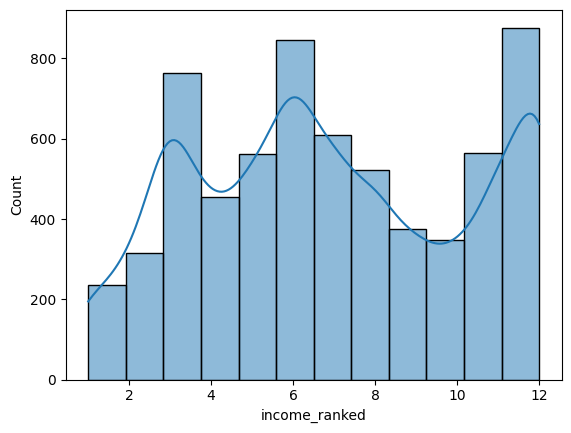

In [88]:
sns.histplot(data = nhgh,
            x = 'income_ranked',
            bins= 12,
            kde=True)

In [89]:
nhgh['income_ranked'].describe()

count      6475.0
mean     6.936062
std       3.33102
min           1.0
25%           4.0
50%           7.0
75%          10.0
max          12.0
Name: income_ranked, dtype: Float64

In [90]:
def apply_logic(value):
    if value >= 6.5:
        return 1
    else:
        return 0

# Apply the function to the 'gh' column using apply()
nhgh['gh_binary'] = nhgh['gh'].apply(lambda x: apply_logic(x))

In [91]:
nhgh

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,...,armc,waist,tri,sub,gh,albumin,bun,SCr,income_ranked,gh_binary
0,51624,male,34.166667,Non-Hispanic White,"25000,35000",0,0,87.4,164.7,32.22,...,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94,6,0
1,51626,male,16.833333,Non-Hispanic Black,"45000,55000",0,0,72.3,181.3,22.00,...,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89,8,0
2,51628,female,60.166667,Non-Hispanic Black,"10000,15000",1,1,116.8,166.0,42.39,...,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11,3,0
3,51629,male,26.083333,Mexican American,"25000,35000",0,0,97.6,173.0,32.61,...,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80,6,0
4,51630,female,49.666667,Non-Hispanic White,"35000,45000",0,0,86.7,168.4,30.57,...,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,male,33.000000,Mexican American,"35000,45000",0,0,94.3,163.5,35.28,...,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97,7,0
6791,62156,female,48.916667,Non-Hispanic White,"0,5000",0,1,87.1,156.9,35.38,...,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89,1,0
6792,62157,male,27.500000,Other Hispanic,"35000,45000",0,0,57.0,164.3,21.12,...,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94,7,0
6793,62158,male,75.750000,Non-Hispanic Black,"10000,15000",0,0,75.1,162.7,28.37,...,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34,3,0


## sqlite3 database relation and design

In [92]:
nhgh

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,...,armc,waist,tri,sub,gh,albumin,bun,SCr,income_ranked,gh_binary
0,51624,male,34.166667,Non-Hispanic White,"25000,35000",0,0,87.4,164.7,32.22,...,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94,6,0
1,51626,male,16.833333,Non-Hispanic Black,"45000,55000",0,0,72.3,181.3,22.00,...,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89,8,0
2,51628,female,60.166667,Non-Hispanic Black,"10000,15000",1,1,116.8,166.0,42.39,...,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11,3,0
3,51629,male,26.083333,Mexican American,"25000,35000",0,0,97.6,173.0,32.61,...,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80,6,0
4,51630,female,49.666667,Non-Hispanic White,"35000,45000",0,0,86.7,168.4,30.57,...,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,male,33.000000,Mexican American,"35000,45000",0,0,94.3,163.5,35.28,...,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97,7,0
6791,62156,female,48.916667,Non-Hispanic White,"0,5000",0,1,87.1,156.9,35.38,...,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89,1,0
6792,62157,male,27.500000,Other Hispanic,"35000,45000",0,0,57.0,164.3,21.12,...,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94,7,0
6793,62158,male,75.750000,Non-Hispanic Black,"10000,15000",0,0,75.1,162.7,28.37,...,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34,3,0


In [93]:
# cursor = conn.cursor()

In [94]:
demographics = nhgh[['seqn', 'sex', 'age', 're', 'income', 'income_ranked']].copy()
demographics.drop_duplicates(subset='seqn', inplace=True)
demographics.index = demographics['seqn']

In [95]:
print(pd.io.sql.get_schema(demographics, 'demographics'))

CREATE TABLE "demographics" (
"seqn" INTEGER,
  "sex" TEXT,
  "age" REAL,
  "re" TEXT,
  "income" TEXT,
  "income_ranked" INTEGER
)


In [96]:
health_metrics = nhgh[['seqn', 'tx', 'dx', 'gh','gh_binary', 'albumin', 'bun', 'SCr']].copy()

In [97]:
print(pd.io.sql.get_schema(health_metrics, 'health_metrics'))

CREATE TABLE "health_metrics" (
"seqn" INTEGER,
  "tx" INTEGER,
  "dx" INTEGER,
  "gh" REAL,
  "gh_binary" INTEGER,
  "albumin" REAL,
  "bun" REAL,
  "SCr" REAL
)


In [98]:
physical_measurements = nhgh[['seqn', 'wt', 'ht', 'bmi', 'leg', 'arml', 'armc', 'waist', 'tri', 'sub']].copy()

In [99]:
print(pd.io.sql.get_schema(physical_measurements, 'physical_measurements'))

CREATE TABLE "physical_measurements" (
"seqn" INTEGER,
  "wt" REAL,
  "ht" REAL,
  "bmi" REAL,
  "leg" REAL,
  "arml" REAL,
  "armc" REAL,
  "waist" REAL,
  "tri" REAL,
  "sub" REAL
)


In [100]:
nhgh_conn = sqlite3.connect('nhgh.db')
# Create Demographics Dimension Table DataFrame
demographics_df = nhgh[['seqn', 'sex', 'age', 're','income','income_ranked']].copy()
demographics_df.to_sql('demographics', nhgh_conn, if_exists='replace', index=False)

# Create Health Status Dimension Table DataFrame
health_status_df = nhgh[['seqn', 'tx', 'dx', 'gh', 'gh_binary','albumin', 'bun', 'SCr']].copy()
health_status_df.to_sql('health_metrics', nhgh_conn, if_exists='replace', index=False)

# Create Physical Measurements Dimension Table DataFrame
physical_measurements_df = nhgh[['seqn', 'wt', 'ht', 'bmi', 'leg', 'arml', 'armc', 'waist', 'tri', 'sub']].copy()
physical_measurements_df.to_sql('physical_measurements', nhgh_conn, if_exists='replace', index=False)

6795

In [101]:
c = nhgh_conn.cursor()

In [102]:
# Create new tables with PK and FK constraints
c.execute('''
    CREATE TABLE IF NOT EXISTS "new_demographics" (
        "seqn" INTEGER PRIMARY KEY,
        "sex" TEXT,
        "age" REAL,
        "re" TEXT,
        "income" TEXT,
        "income_ranked" INTEGER
    );
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS "new_health_metrics" (
        "seqn" INTEGER,
        "tx" INTEGER,
        "dx" INTEGER,
        "gh" REAL,
        "gh_binary" INTEGER,
        "albumin" REAL,
        "bun" REAL,
        "SCr" REAL,
        FOREIGN KEY (seqn) REFERENCES new_demographics(seqn)
    );
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS "new_physical_measurements" (
        "seqn" INTEGER,
        "wt" REAL,
        "ht" REAL,
        "bmi" REAL,
        "leg" REAL,
        "arml" REAL,
        "armc" REAL,
        "waist" REAL,
        "tri" REAL,
        "sub" REAL,
        FOREIGN KEY (seqn) REFERENCES new_demographics(seqn)
    );
''')

# Copy data to new tables
c.execute('''
    INSERT INTO new_demographics (seqn, sex, age, re, income, income_ranked)
    SELECT seqn, sex, age, re, income, income_ranked FROM demographics;
''')

c.execute('''
    INSERT INTO new_health_metrics (seqn, tx, dx, gh, gh_binary, albumin, bun, SCr)
    SELECT seqn, tx, dx, gh, gh_binary, albumin, bun, SCr FROM health_metrics;
''')

c.execute('''
    INSERT INTO new_physical_measurements (seqn, wt, ht, bmi, leg, arml, armc, waist, tri, sub)
    SELECT seqn, wt, ht, bmi, leg, arml, armc, waist, tri, sub FROM physical_measurements;
''')

# Drop old tables
c.execute('DROP TABLE IF EXISTS demographics;')
c.execute('DROP TABLE IF EXISTS health_metrics;')
c.execute('DROP TABLE IF EXISTS physical_measurements;')

# Rename new tables to original names
c.execute('ALTER TABLE new_demographics RENAME TO demographics;')
c.execute('ALTER TABLE new_health_metrics RENAME TO health_metrics;')
c.execute('ALTER TABLE new_physical_measurements RENAME TO physical_measurements;')

# Commit changes and close connection
nhgh_conn.commit()


In [103]:
nhgh_conn = sqlite3.connect('nhgh.db')

In [104]:
c = nhgh_conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()

for table in tables:
    table_name = table[0]
    c.execute(f"SELECT COUNT(*) FROM {table_name};")
    row_count = c.fetchone()[0]
    print(f"Table: {table_name}, Row Count: {row_count}")

    c.execute(f"PRAGMA foreign_key_list({table_name});")
    foreign_keys = c.fetchall()
    if foreign_keys:
        print("Foreign Key Relationships:")
        for fk in foreign_keys:
            print(f"  {fk[3]} -> {fk[2]}")

Table: respondent_data, Row Count: 6795
Table: demographics, Row Count: 6795
Table: health_metrics, Row Count: 6795
Foreign Key Relationships:
  seqn -> demographics
Table: physical_measurements, Row Count: 6795
Foreign Key Relationships:
  seqn -> demographics


In [105]:
tables = ['respondent_data', 'demographics', 'health_metrics', 'physical_measurements']

# Check number of rows in each table
for table in tables:
    c.execute(f"SELECT COUNT(*) FROM {table}")
    count = c.fetchone()[0]
    print(f"Table '{table}' has {count} rows.")


Table 'respondent_data' has 6795 rows.
Table 'demographics' has 6795 rows.
Table 'health_metrics' has 6795 rows.
Table 'physical_measurements' has 6795 rows.


## Dealing with null values

The following code will format our null values in the following way:

| Columns   | % of Null | Count of Null |
|-----------|-----------|---------------|
|           |           |               |


In [106]:
# pd.read_sql("SELECT * FROM nhgh",conn)

In [107]:
na_summary = nhgh.isna().sum()
na_summary_null_only = na_summary[na_summary > 0].sort_values(ascending=False)
nhgh_null = round(na_summary_null_only / nhgh.shape[0] * 100, 2)

In [108]:
null_summary_table = pd.DataFrame({
    'Columns': na_summary_null_only.index,
    '% of Null': nhgh_null.values,
    'Count of Null': na_summary_null_only.values
})


In [109]:
null_summary_table

,Columns,% of Null,Count of Null
0,sub,14.29,971
1,tri,7.08,481
2,income,4.71,320
3,income_ranked,4.71,320
4,waist,3.52,239
5,leg,3.40,231
6,armc,2.77,188
7,arml,2.63,179
8,albumin,1.31,89
9,bun,1.31,89


income im dealing with
for sub and tri use some sort of impute LATER in train test split
for waist as well, leg as well, armc as well, arml as well, albumin,bun and SCr need to decide on an imputation method

### data type specific visualisation

In [110]:
all_int_object = pd.read_sql("""
SELECT sex,re,income_ranked,tx,dx
FROM demographics
JOIN health_metrics ON demographics.seqn = health_metrics.seqn;
""",nhgh_conn)

In [111]:
all_int_object.dtypes

sex               object
re                object
income_ranked    float64
tx                 int64
dx                 int64
dtype: object

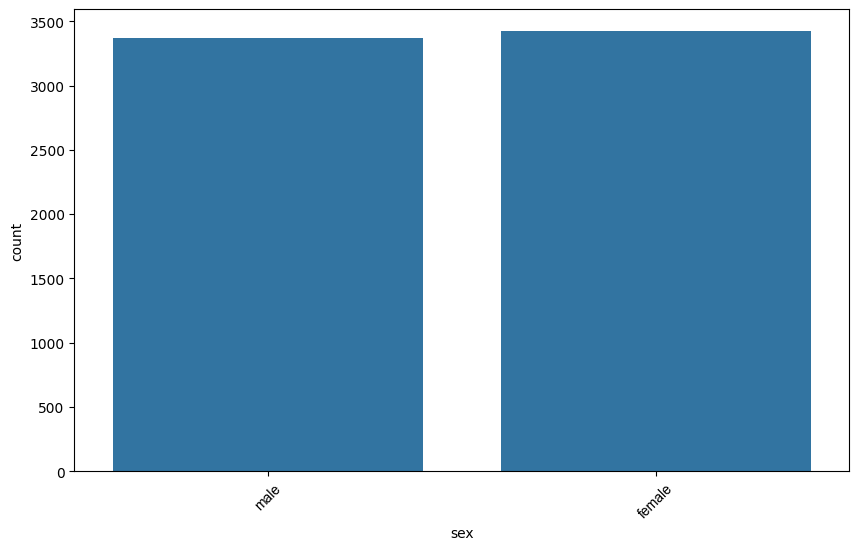

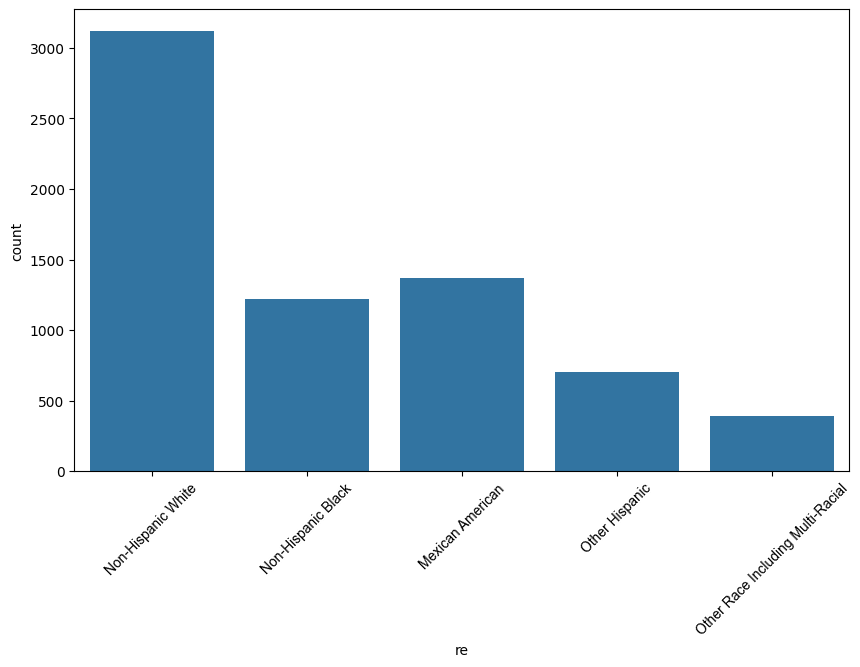

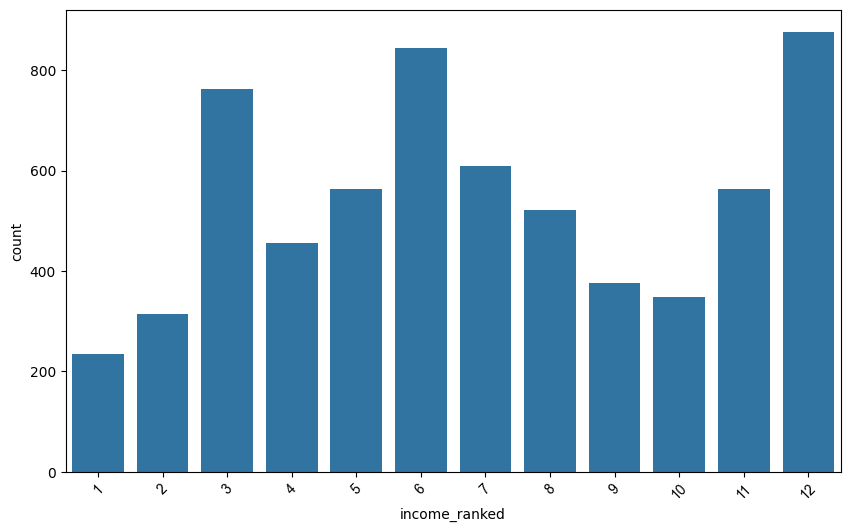

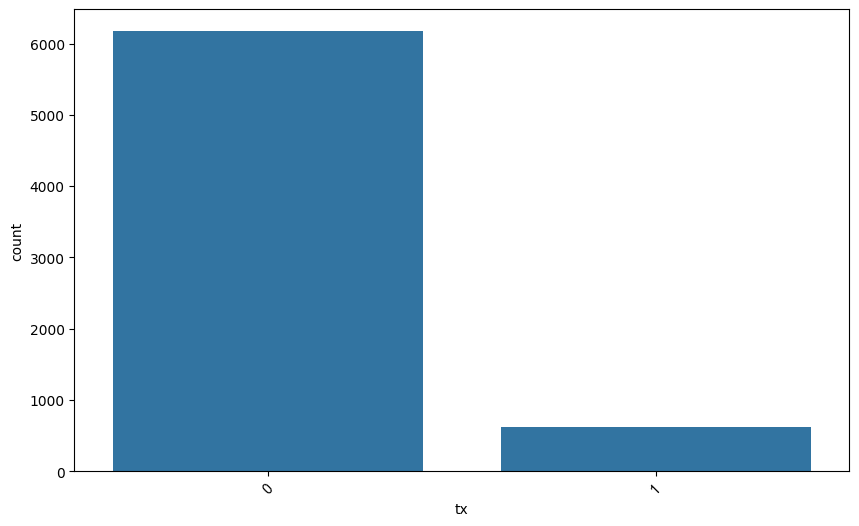

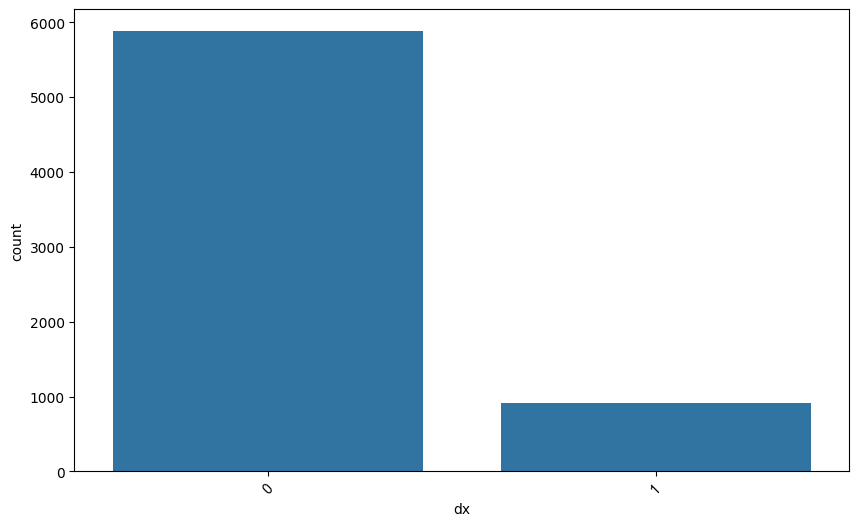

In [112]:
for column in all_int_object:
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=45, fontname='Arial', fontsize=10) 
    sns.countplot(data=nhgh, x=column)


In [113]:
health_physical = pd.read_sql(
'''
SELECT h.*, p.*, d.age
FROM health_metrics h
JOIN physical_measurements p ON h.seqn = p.seqn
JOIN demographics d ON h.seqn = d.seqn
''',nhgh_conn)

In [114]:
health_physical.drop(columns = ['seqn','tx','dx'],inplace=True)

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


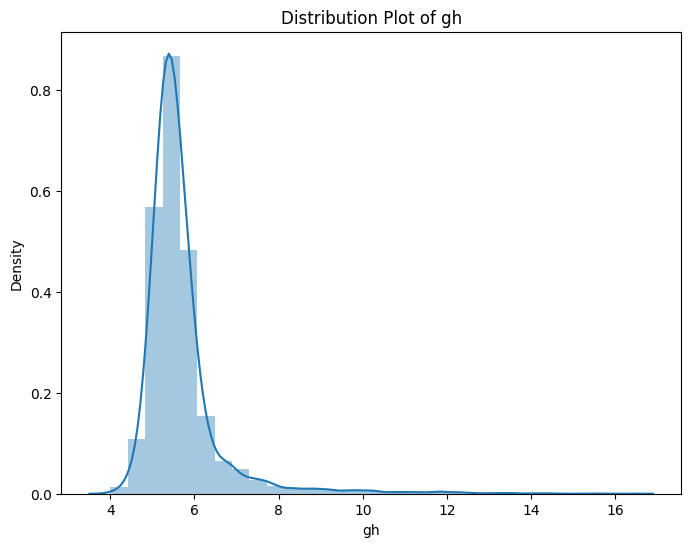

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


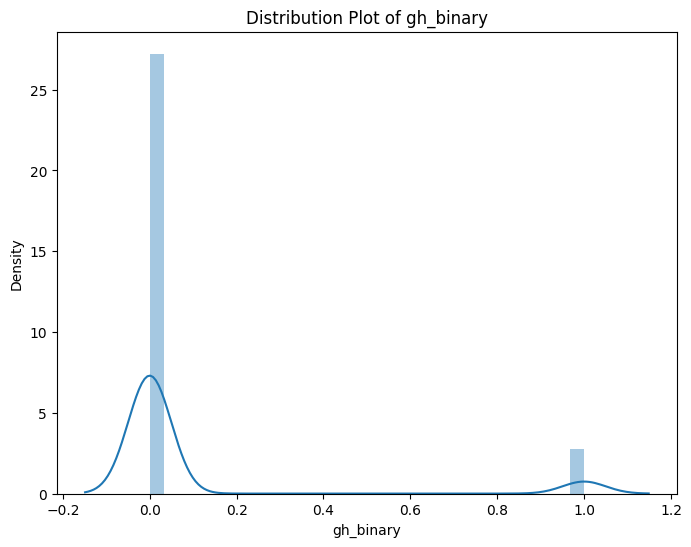

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


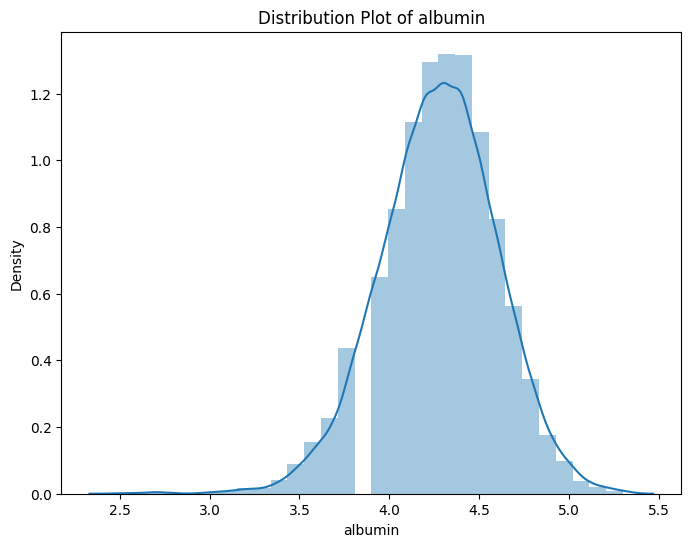

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


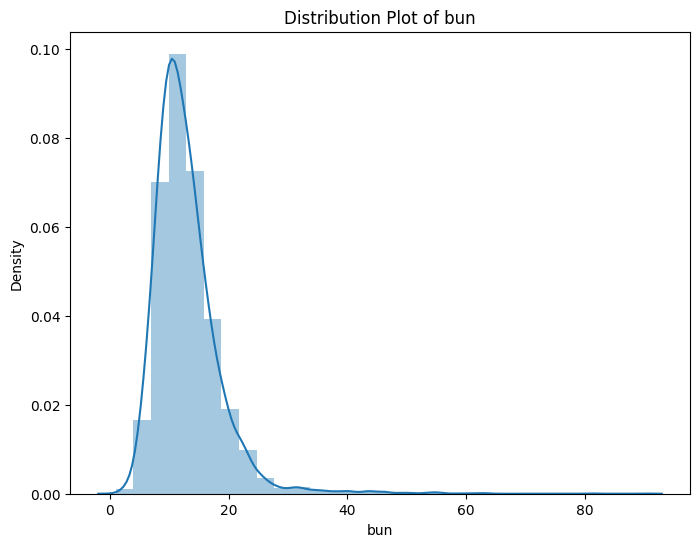

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


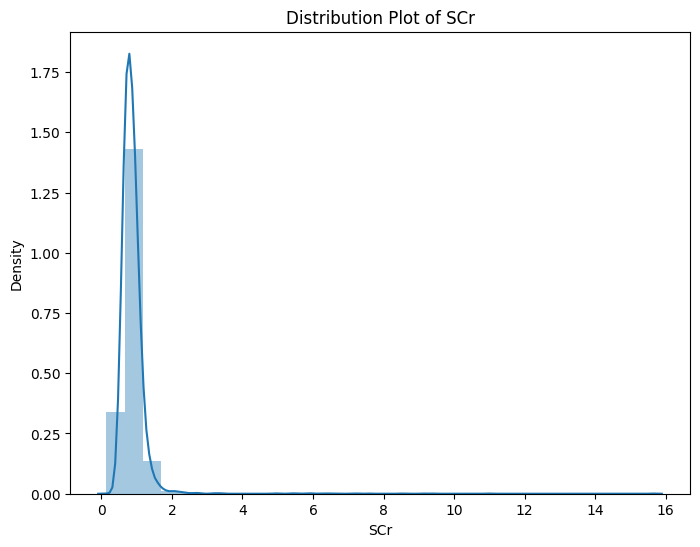

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


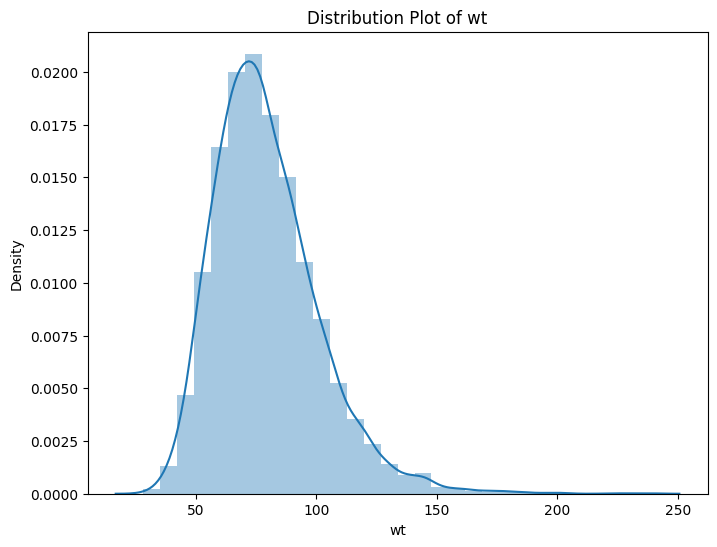

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


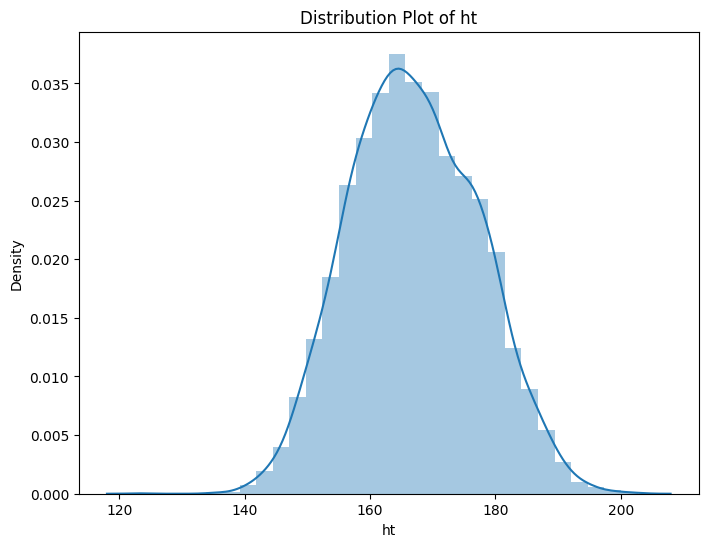

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


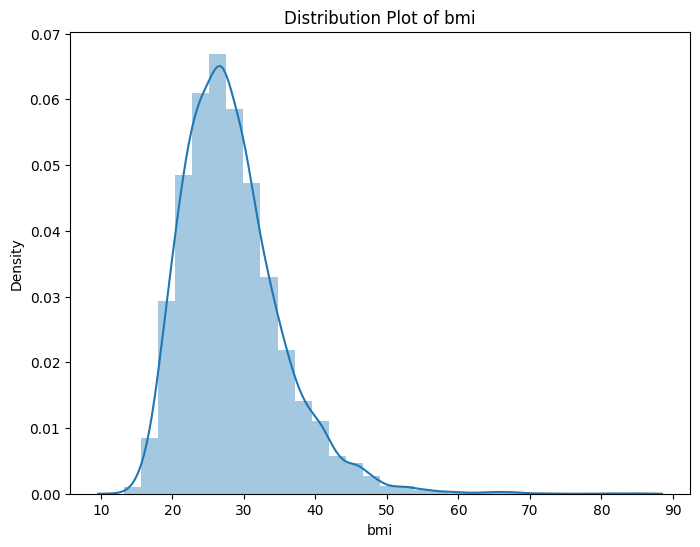

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


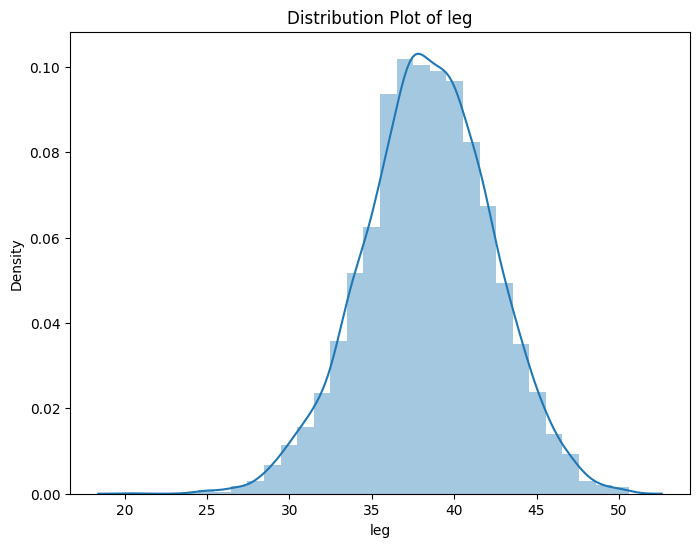

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


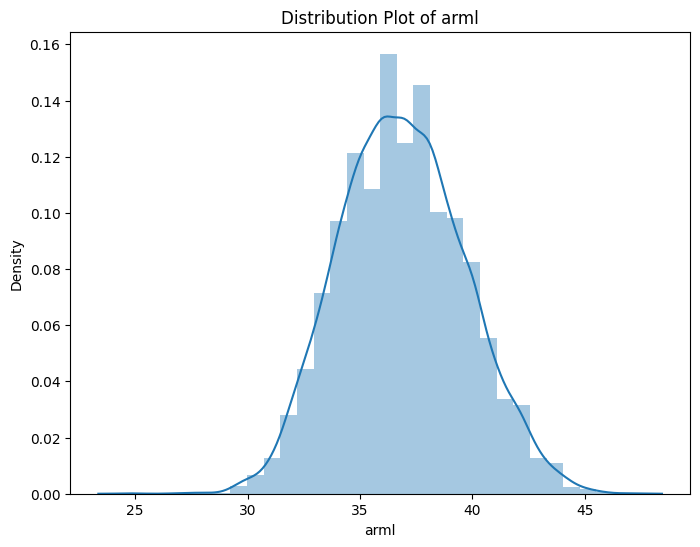

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


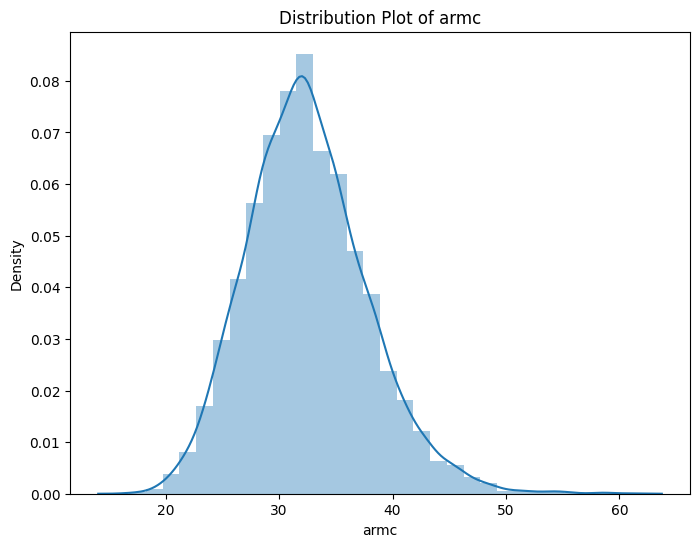

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


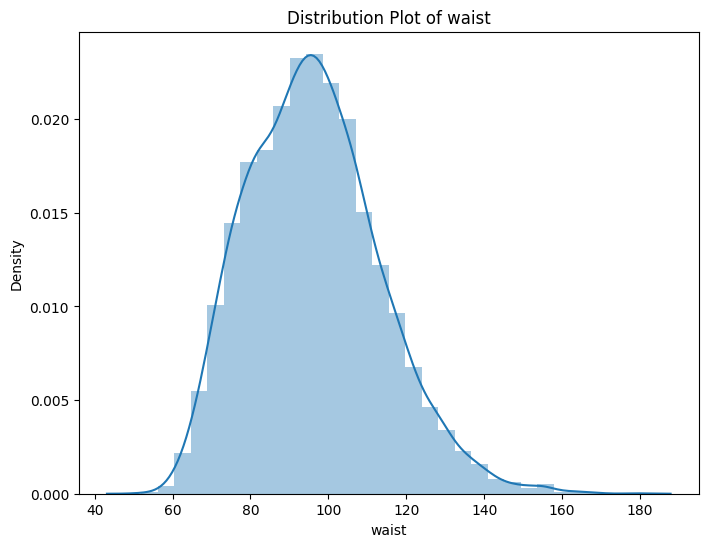

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


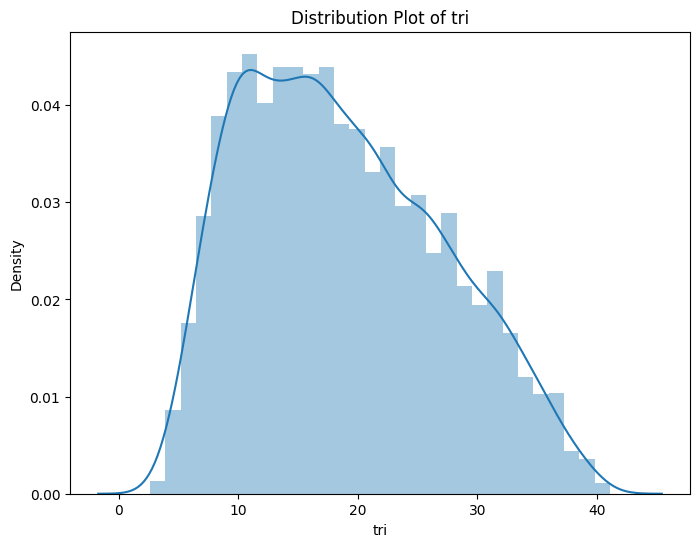

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


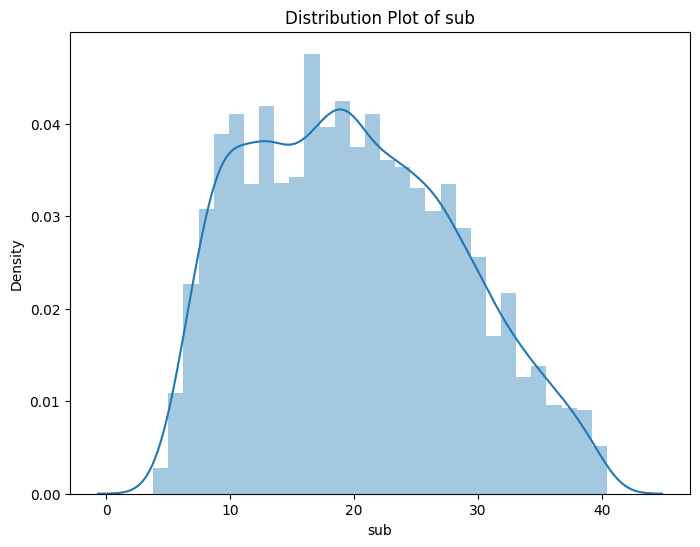

C:\Users\siaza\AppData\Local\Temp\ipykernel_9556\662613356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nhgh[column].dropna(), kde=True, bins=30)


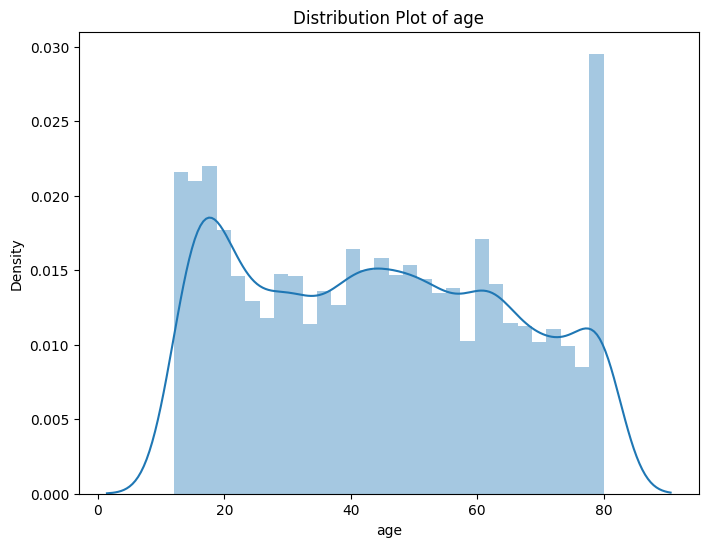

In [115]:
for column in health_physical:
    plt.figure(figsize=(8, 6)) 
    sns.distplot(nhgh[column].dropna(), kde=True, bins=30)
    plt.title(f'Distribution Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

<Axes: xlabel='gh_binary', ylabel='count'>

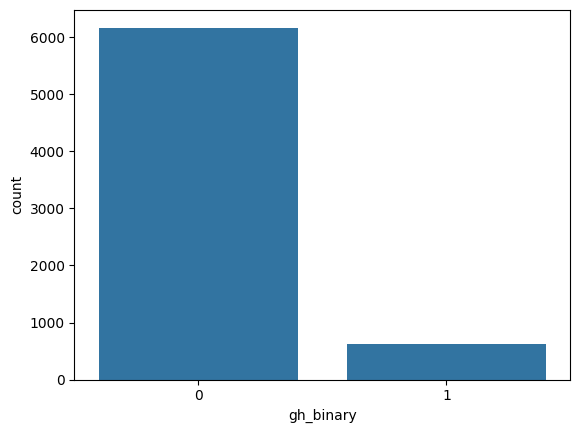

In [116]:
sns.countplot(data = nhgh, x='gh_binary')

## Modelling

The approach will be to test all 3 models mentioned in the pdf assignment, gridsearch the best result and discuss results.

Defining X,y and splitting into train test. As dataset is imbalanced stratified.

In [117]:
X = nhgh.drop(['seqn','gh_binary','gh','gh_binary','income'], axis=1)
y = nhgh['gh_binary']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Used pipelines to organise code.

In [119]:
numeric_features = X.select_dtypes(exclude=['object']).columns.to_list()

In [120]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
    ])


In [121]:
categorical_features = X.select_dtypes('object').columns.to_list()

In [122]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
     ])


In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


### Logistic classification

In [124]:
from sklearn.metrics import classification_report


In [125]:
log_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))])

In [126]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [127]:
y_pred_cv = cross_val_predict(log_model_pipeline, X_train, y_train, cv=kfold)

In [128]:
class_report = classification_report(y_train, y_pred_cv)

In [129]:
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      4934
           1       0.45      0.81      0.58       502

    accuracy                           0.89      5436
   macro avg       0.71      0.86      0.76      5436
weighted avg       0.93      0.89      0.90      5436



### decision tree

In [132]:
DT_model_pipeline = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))])


In [133]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [194]:
y_pred_cv = cross_val_predict(DT_model_pipeline, X_train, y_train, cv=kfold, return_estimator=True)

TypeError: cross_val_predict() got an unexpected keyword argument 'return_estimator'

In [135]:
class_report = classification_report(y_train, y_pred_cv)

In [ ]:
print(class_report)

### Randomforestclassifier no gridsearch

In [136]:
RF_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])

In [137]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [138]:
y_pred_cv = cross_val_predict(RF_model_pipeline, X_train, y_train, cv=kfold)

In [139]:
class_report = classification_report(y_train, y_pred_cv)

In [140]:
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4934
           1       0.69      0.54      0.61       502

    accuracy                           0.94      5436
   macro avg       0.82      0.76      0.79      5436
weighted avg       0.93      0.94      0.93      5436



### Randomforestclassifier with gridsearch

In [141]:
rf_classifier = RandomForestClassifier(random_state=42,class_weight='balanced')

In [161]:

param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create the pipeline with preprocessing, GridSearchCV, and classifier as steps
RF_model_pipeline_gridsearch = Pipeline([
    ('preprocessor', preprocessor),  # Step 1: Preprocessing
    ('grid_search', GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=kfold, scoring='recall', n_jobs=-1))
])

In [190]:
print(classification_rep_gridsearch)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      4934
           1       0.51      0.77      0.61       502

    accuracy                           0.91      5436
   macro avg       0.74      0.85      0.78      5436
weighted avg       0.93      0.91      0.92      5436



In [195]:
RF_model_pipeline_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'tx', 'dx', 'wt',
                                                   'ht', 'bmi', 'leg', 'arml',
                                                   'armc', 'waist', 'tri',
                                                   'sub', 'albumin', 'bun',
                                                   'SCr', 'income_ranked']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('...
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 're'])])),
                ('grid_search',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                              estimator=RandomForestClassifier(class_weight='balanced',
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [None, 5, 10, 15, 20],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 150, 200]},
                              scoring='recall'))])

In [196]:
# Assuming RF_model_pipeline_gridsearch is a pipeline that includes GridSearchCV
grid_search = RF_model_pipeline_gridsearch.named_steps['grid_search']
best_estimator = grid_search.best_estimator_

feature_importances = best_estimator.feature_importances_

# Assuming RF_model_pipeline_gridsearch includes preprocessing steps
preprocessor = RF_model_pipeline_gridsearch.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()


In [200]:
preprocessor = RF_model_pipeline_gridsearch.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

In [201]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [202]:
feature_importance_df

,Feature,Importance
2,num__dx,0.302951
1,num__tx,0.268446
0,num__age,0.126203
9,num__waist,0.074926
5,num__bmi,0.061878
3,num__wt,0.032006
11,num__sub,0.025118
8,num__armc,0.018964
6,num__leg,0.017500
12,num__albumin,0.015644


In [204]:
y_pred_cv_gridsearch = cross_val_predict(RF_model_pipeline_gridsearch, X_train, y_train, cv=kfold)

# Generate a classification report
classification_rep_gridsearch = classification_report(y_train, y_pred_cv_gridsearch)

print(classification_rep_gridsearch)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      4934
           1       0.51      0.77      0.61       502

    accuracy                           0.91      5436
   macro avg       0.74      0.85      0.78      5436
weighted avg       0.93      0.91      0.92      5436



In [198]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

We can see our important features in our feature_importance_df and our best effort grid searched randomforest classifier prediction results.